# Can Twitter Be Used To Predict Changes In a Stock value

## 1 An Introduction To The Problem / field
There is of course a lot of interest in tring to find any sort of information that can help to predict the outcome of the stock markets. As there is a lot of money being traded in the stock markets every day, any edge that can be gain in predicting when and in what direction a stock will change can enable large profits.

Due to the large values of such information there has been a lot of research already and continuing to be done in the field, however most of it hasn't be made public due to the arms race between top stock traders.

Company's stocks are valued based on how much the company is currently worth and how much the company is expected to grow over the coming months and years.

Therefore if you are able to tell when the population's feelings/confidence in a company's value/grow increases or decreases. Then you would expect the stock market value of the to follow that same trend.



## 2 What Data Am I Going To Use
I am planing to curate a list popular companies from the snp 500, this list will also contain the twitter search queries needed to down load the tweets from the company.
I am also going to look at the sentiment and volume of tweets from the public about the company. 
I will do this by searching for tweets use that hash tags

### 2.1 To companies I will review are:
 - Tesla
 - Apple
 - Microsoft
 - Amazon
 - Alphabet
 - Meta
 - Twitter


### 2.2 Stock market
I am going to collect the stock data from yahoo finance library, this greatly increases the easy for downloading this data

#### 2.2.1 Ethical Impact
##### **Collection and distribution of collected data?**
All of this data is already public and easy to review and collect, there for this project doesn't make it any easier for anyone

##### **Impact of Findings?**


##### **Is the Data Personally Identifiable?**
N/A

##### **biases in the data?**
I have only selected companies that I know of and they are all Tech based companies.
Each of these Companies are know success as they have been selected for the snp 500.

Due to this selection process bias I expect these companies will be more linked to twitter then other Companies.

Therefore this cannot be used a confirmation for other stocks as it's isn't representative of all stocks


### 2.3 Twitter
I original looked at using Twitter's API to collect all the of tweets,
however it was harder to use and it also added a rate limit on hte number of tweets that I could collect.
I realised that the limits would be too low for what I was wanting to do. But I found the snscrape library, this offers a much easier experience, with no cap and also allowing to easily expand the scope to other social networks as well if I want.

#### 2.3.1 Ethical Impact
##### **Collection and distribution of collected data?**


##### **Impact of Findings?**
If this project is found to show that tweets can provide signals to the a stocks future performance, then this could encourage further work into these tweets.
I cannot guarantee how others will review this data, but they could end up using it in non ethical ways.
Also due to the amount of money in this area, a lot of money could be put in to extra data collection that might be Personally Identifiable

##### **Is the Data Personally Identifiable?**
The raw data that is collected is Personally Identifiable.
However always review the aggregated values from the tweets never single tweets.


##### **biases in the data?**
The public sentiment about the companies are collected from tweets that contain hash tags that i felt were relevant.
There could also be a lot of tweets about the companies that didn't include hashtags. so there is a selection bias to users/ tweets that meet that criteria.

As some of the companies i am reviewing are social networks, there is likely far more bias, due to the data only being collected from twitter.
I would expect twitter users to be more positive about twitter and less so about facebook(meta).




In [21]:
# Import libraries and modules

#yahoo finance to down load the relevent stock market data
import yfinance as yf

# social network scrape to download the tweets from twitter
import snscrape.modules.twitter as sntwitter

#libraries for cleaning the data
import pandas as pd
import numpy as np

#libraries for file read and writing
import json
import os

#libraries for parsing and converting date time formats
from datetime import datetime
from dateutil import parser

#libraries for analyzing the sentiment of the tweets
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as SentimentAnalyzer
sentimentAnalyzer = SentimentAnalyzer()

#libraries for plotting data
import matplotlib.pyplot as plt
from matplotlib import style

# Show all matplotlib graphs inline
%matplotlib inline  
# using the style for the plot
plt.style.use('dark_background')
# set plot size
plt.rcParams['figure.figsize'] = [30, 15]


## 3 Limitations To Project Scope
This is is a very large field that can be researched for a life time so I have to limit the scope of the project, as I have a 4 week time limit.

I did experiment with a wider scope, but the extended time needed for computation reduced my ability to iterate.
I wanted to focus on a few companies at a deeper evaluation instead of little to no value of evaluation spread over more stocks.

#### 3.1 Stock Data:
 - I am not going to look at all trades happening in each day only the open price and volume
 - I am only going to look at the last 10 years of data

#### 3.2 Twitter Data:
 - First of all I will review the tweets that are sent from the company or it's CEO
 - then look at all tweets about the company
  - this will be limited to the when the company's hashtags are used in tweets.



In [22]:
#Scope Limits

# Limit the time range that I am going to review
StartTime = "2012-05-01"
EndTime = "2022-05-01"

# what counts as a jump in values 
MinDaysBetweenJumps = 7

StockJumpTriggerRatio = 0.5
StockJumpTriggerPercentage = 1

# twitter's data is more volatile so needs a larger threshold
TwitterJumpTriggerRatio = 1.25
TwitterJumpTriggerPercentage = 7.5

#Where to cache data
TweetCacheFolder_Small = "CachedTweets_Small"
TweetCacheFolder_Large = "CachedTweets_Large"
StockCacheFolder = "CachedStockData"

TweetCacheDict = {}
StockCacheDict = {}

In [23]:
#what users do we care about
with open("config.json", "r") as file:
	companiesToReview = json.load(file)

In [24]:
def StrToDate(date):
	try:
		date = parser.parse(date)
	except:
		raise Exception("invalid date: " + str(date) + " Of type: " + str(type(date)))
	
	
	date = datetime(date.year, date.month, date.day)
	return date

In [25]:
def GetTweetSentiment(text):
	scores = sentimentAnalyzer.polarity_scores(text)
	return scores["compound"]

In [26]:
def GetTweetsFromAboutCompany(companyData, isPublicOpinion=False):

	tweetCacheFolder = TweetCacheFolder_Small
	dictKey = companyData["StockName"]

	if isPublicOpinion: 
		tweetCacheFolder =TweetCacheFolder_Large
		dictKey += "_isPublicOpinion"

	if not os.path.isdir(tweetCacheFolder):
		os.mkdir(tweetCacheFolder)

	cachePath = os.path.join(tweetCacheFolder, "tweets_" + companyData["StockName"] + ".csv")

	#dict cache exists
	if dictKey in TweetCacheDict:
		df = TweetCacheDict[dictKey]

	# file cache exists
	else:
		if os.path.exists(cachePath):
			df = pd.read_csv(cachePath)

			

		else:
			# build the query
			query = "("

			twitterUsernames = companyData["TwitterUsernames"]
			twitterHashTags = companyData["TwitterHashTags"]
			twitterPhrases = companyData["TwitterPhrases"]

			for i in range(len(twitterUsernames)):
				query += "from:" + twitterUsernames[i]
				if i < len(twitterUsernames) - 1:
					query += " OR "

			if isPublicOpinion:
				query += ") OR ("

				for i in range(len(twitterHashTags)):
					query += twitterHashTags[i]
					if i < len(twitterHashTags) - 1:
						query += " OR "

			query += ") since:" + StartTime + " until:" + EndTime + " -filter:links -filter:replies"
			
			# get tweets that match the query
			tweets = []
			for tweet in sntwitter.TwitterSearchScraper(query).get_items():
				sentiment = GetTweetSentiment(tweet.content)
				tweets.append([tweet.date, tweet.user.username, tweet.content, tweet.replyCount, tweet.retweetCount, tweet.likeCount, tweet.quoteCount, tweet.id, sentiment])

			df = pd.DataFrame(tweets, columns=['Date', 'User', 'Content', 'ReplyCount', 'RetweetCount', 'LikeCount', 'QuoteCount', 'TweetID', 'Sentiment'])

			# to save to csv as a cache
			df.to_csv(cachePath)

		for i in range(len(df)):
			df["Date"][i] = StrToDate(df["Date"][i])

		df = df.sort_values(by=['Date'])
		TweetCacheDict[dictKey] = df
	


	return df

In [27]:
def LoadStockData(stockTag):

	if not os.path.isdir(StockCacheFolder):
		os.mkdir(StockCacheFolder)

	cachePath = os.path.join(StockCacheFolder, "Stock_" + stockTag + ".csv")

	#dict cache exists
	if stockTag in TweetCacheDict:
		stockDataDf = TweetCacheDict[stockTag]

	# file cache exists
	else:
		if os.path.exists(cachePath):
			stockDataDf = pd.read_csv(cachePath)
			
		else:
			stockDataDf = yf.download(stockTag, start=StartTime, end=EndTime, progress=False)

			#save data to local cache file
			stockDataDf.to_csv(cachePath)


		for i in range(len(stockDataDf)):
			stockDataDf["Date"][i] = StrToDate(stockDataDf["Date"][i])

		stockDataDf = stockDataDf.sort_values(by=['Date'])
		TweetCacheDict[stockTag] = stockDataDf

	
	return stockDataDf

In [28]:
def CreateMovingAverage(df, columnToAverage, averageLength):

	movingAverage = []
	movingAverageUpperQuantile = []
	movingAverageLowerQuantile = []

	rows = df.loc[:,columnToAverage]
	for i in range(len(rows)):

		# get window
		if i < averageLength:
			window = [0]
		else:
			window = rows[i - averageLength : i]

		# calculate moving avg
		windowAverage = round(sum(window) / averageLength, 2)
		movingAverage.append(windowAverage)

		# calculate UpperQuantile
		upperQuantile = np.quantile(window, 0.9)
		movingAverageUpperQuantile.append(upperQuantile)

		# calculate LowerQuantile
		lowerQuantile = np.quantile(window, 0.1)
		movingAverageLowerQuantile.append(lowerQuantile)

	df.insert(len(df.columns), columnToAverage + "MA_" + str(averageLength), movingAverage, allow_duplicates=True)
	df.insert(len(df.columns), columnToAverage + "MA_" + str(averageLength) + "_UpperQuantile", movingAverageUpperQuantile, allow_duplicates=True)
	df.insert(len(df.columns), columnToAverage + "MA_" + str(averageLength) + "_LowerQuantile", movingAverageLowerQuantile, allow_duplicates=True)
	return

In [29]:
def DetectValueJumping(df, column, lastValueColumn, currentValueColumn, jumpTriggerRatio, jumpTriggerPercentage):
	isValueJumping = []

	for i in range(len(df)):

		# get window
		if i < 45: #skip the first few days as the moving averages take a few days to settle
			isJump = False
		else:
			upperQuantile = df[column + "MA_7MA_30_UpperQuantile"][i]
			lowerQuantile = df[column + "MA_7MA_30_LowerQuantile"][i]
			lastValue = df[lastValueColumn][i]
			currentValue = df[currentValueColumn][i]

			interQuantileRange = upperQuantile - lowerQuantile
			triggerRange = jumpTriggerRatio * interQuantileRange

			meantRatio = currentValue > upperQuantile + triggerRange or currentValue < lowerQuantile - triggerRange

			meantPercentage = False
			if lastValue != 0:
				meantPercentage = abs(lastValue - currentValue) / lastValue > jumpTriggerPercentage / 100
			
			isJump = meantRatio and meantPercentage

		isValueJumping.append(isJump)

	df.insert(len(df.columns), column + "_IsJumping", isValueJumping, allow_duplicates=True)

	return

def CreateStockTrendData(stockData):

	CreateMovingAverage(stockData, "Volume", 3)
	CreateMovingAverage(stockData, "Volume", 7)
	CreateMovingAverage(stockData, "VolumeMA_7", 30)

	CreateMovingAverage(stockData, "Open", 3)
	CreateMovingAverage(stockData, "Open", 7)
	CreateMovingAverage(stockData, "OpenMA_7", 30)

	DetectStockJumps(stockData)

	return

def DetectStockJumps(stockData):

	DetectValueJumping(stockData, "Volume", "VolumeMA_7", "VolumeMA_3",
		StockJumpTriggerRatio, StockJumpTriggerPercentage)
	DetectValueJumping(stockData, "Open", "OpenMA_3", "Open",
		StockJumpTriggerRatio, StockJumpTriggerPercentage)

	
	bothJumped = stockData["Volume_IsJumping"] * stockData["Open_IsJumping"]
	stockData.insert(len(stockData.columns), "Both_IsJumping", bothJumped, allow_duplicates=True)

	eitherJumped = stockData["Volume_IsJumping"] + stockData["Open_IsJumping"]
	stockData.insert(len(stockData.columns), "Either_IsJumping", eitherJumped, allow_duplicates=True)

	return

def DetectTweetJumps(tweetData):
	CreateMovingAverage(tweetData, "avgSentiment", 3)
	CreateMovingAverage(tweetData, "avgSentiment", 7)
	CreateMovingAverage(tweetData, "avgSentiment", 30)
	CreateMovingAverage(tweetData, "avgSentimentMA_7", 30)

	DetectValueJumping(tweetData, "avgSentiment", "avgSentimentMA_7MA_30", "avgSentimentMA_7",
		TwitterJumpTriggerRatio, TwitterJumpTriggerPercentage)

	return


In [30]:
#get the dates that values jump
def GetValueJumpsDates(stockData, jumpColumn):

	dates = []
	daysSinceLastJump = MinDaysBetweenJumps

	for i in range(len(stockData)):
		daysSinceLastJump += 1

		isJump = stockData[jumpColumn][i]

		if isJump and daysSinceLastJump >= MinDaysBetweenJumps:
			dates.append(stockData["Date"][i])
			daysSinceLastJump = 0

	return dates

In [31]:
#down load all needed data to local cache
# then clean up the data
for companyData in companiesToReview:
	GetTweetsFromAboutCompany(companyData)

	tweetData = GetTweetsFromAboutCompany(companyData, isPublicOpinion=True)

	DetectTweetJumps(tweetData)

	companyData["TweetJumpDates"] = GetValueJumpsDates(tweetData, "avgSentiment_IsJumping")
	

	stockData = LoadStockData(companyData["Tag"])
	CreateStockTrendData(stockData)
	companyData["StockJumpDates"] = GetValueJumpsDates(stockData, "Both_IsJumping")



C:\Users\LOUIE~1.JON\AppData\Local\Temp/ipykernel_21176/2580432827.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"][i] = StrToDate(df["Date"][i])
C:\Users\LOUIE~1.JON\AppData\Local\Temp/ipykernel_21176/2580432827.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"][i] = StrToDate(df["Date"][i])
C:\Users\LOUIE~1.JON\AppData\Local\Temp/ipykernel_21176/3178137230.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

## 4 Check the data is valid

Now that the data is all down loaded, we need to check that it looks correct

### 4.1 How I Am Checking The Stock Data
I am going to create two plots each of stock one of the open price over time and one of the volume over time
### 4.2 How I Am Checking The Twitter Data

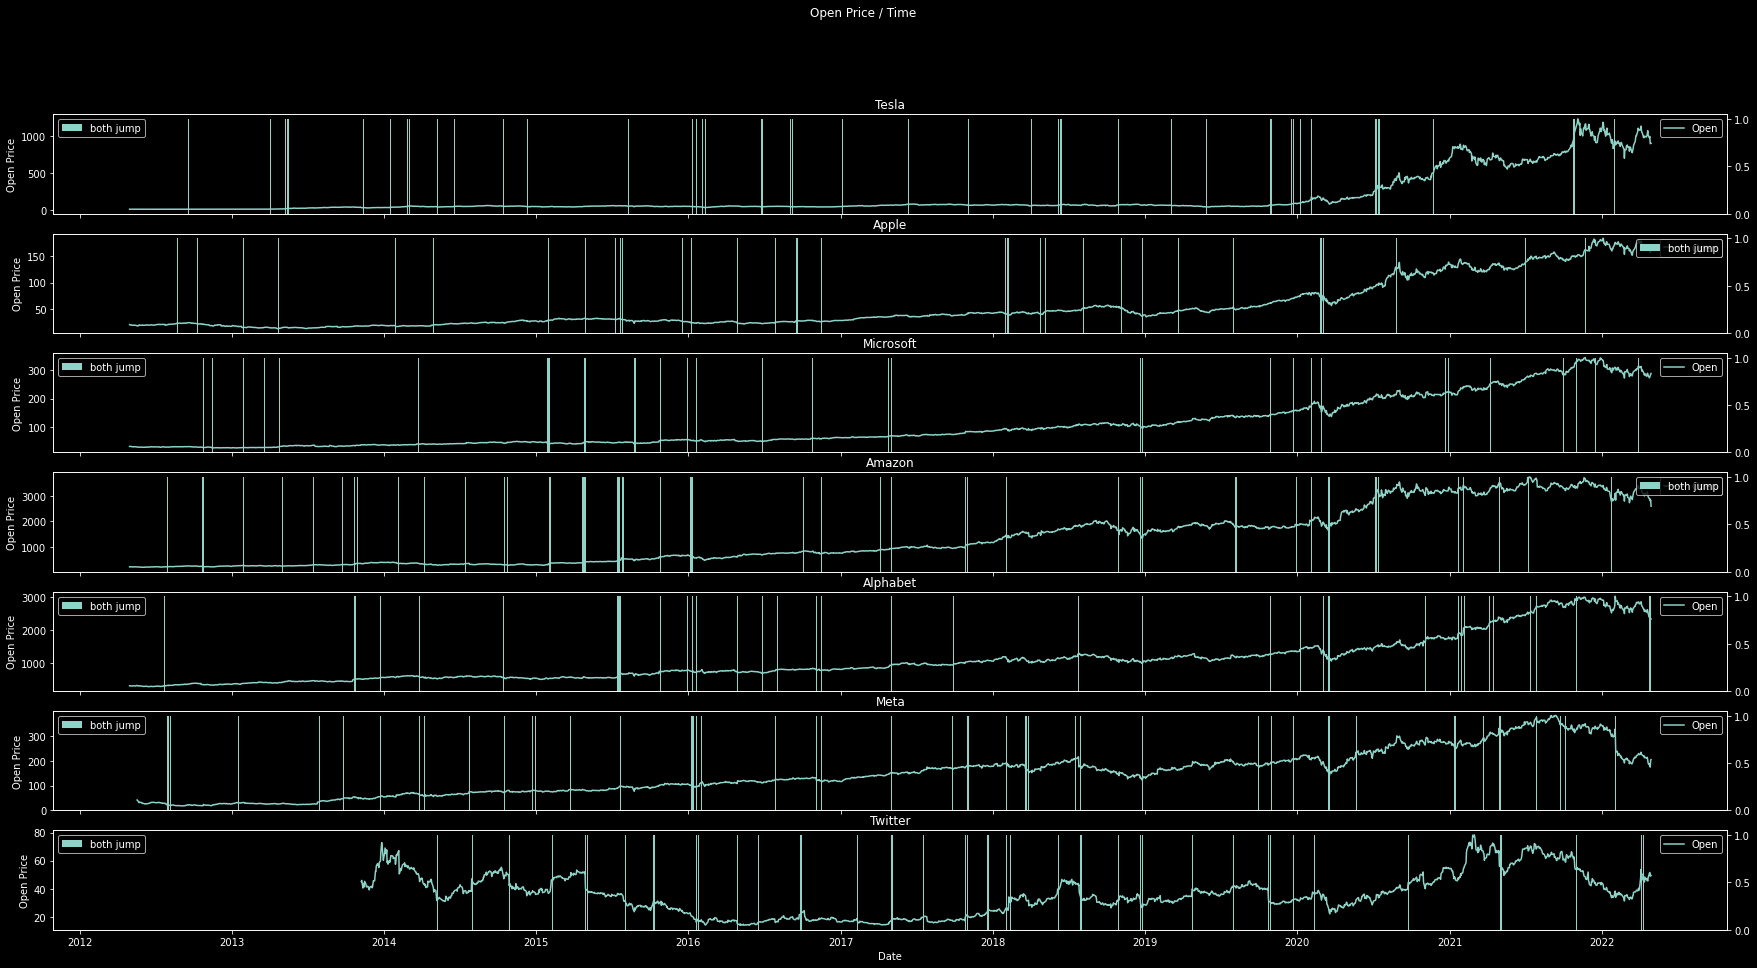

In [32]:
fig, axs = plt.subplots(len(companiesToReview), sharex=True)
fig.suptitle("Open Price / Time")

for i in range(len(companiesToReview)):
	stockData = LoadStockData(companiesToReview[i]["Tag"])

	axs[i].set_title(companiesToReview[i]["StockName"])
	axs[i].plot(stockData["Date"], stockData["Open"], label = "Open")
	
	axs[i].set(xlabel='Date', ylabel='Open Price')
	axs[i].label_outer()
	axs[i].legend()

	ax2 = axs[i].twinx()
	# ax2.bar(stockData["Date"], stockData["Open_IsJumping"], label="open jump")
	ax2.bar(stockData["Date"], stockData["Both_IsJumping"], label="both jump")

	ax2.legend()
plt.show()

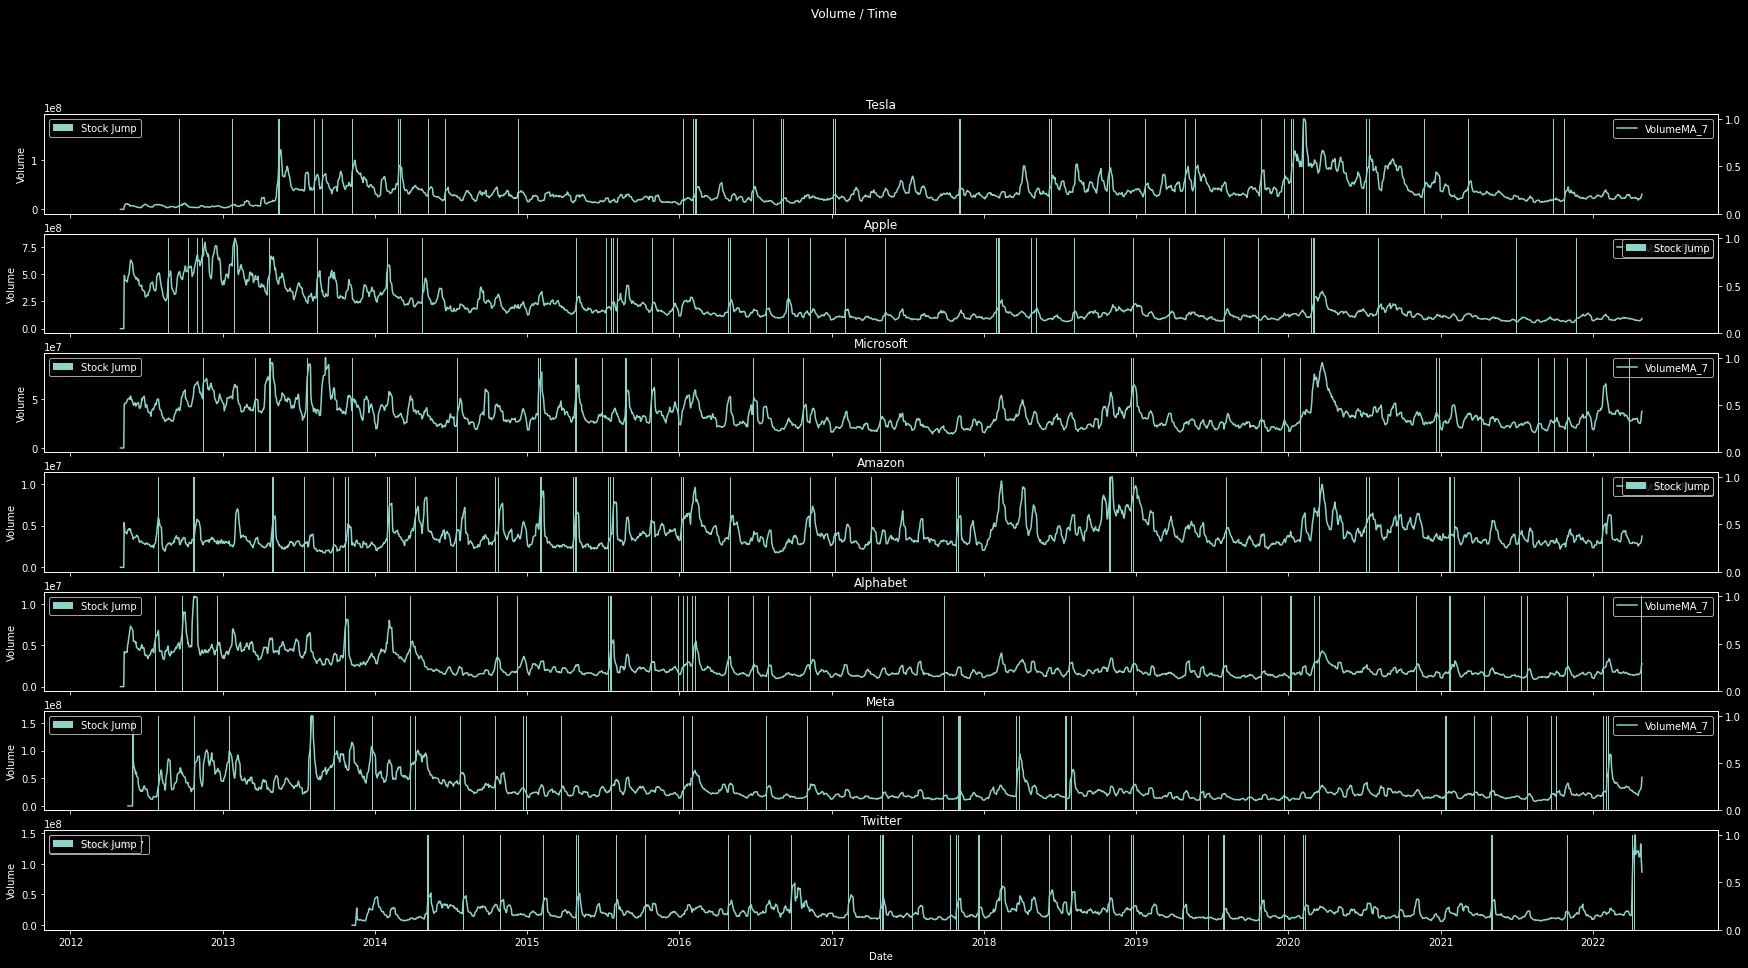

In [33]:

fig, axs = plt.subplots(len(companiesToReview), sharex=True)
fig.suptitle("Volume / Time")

for i in range(len(companiesToReview)):
	stockData = LoadStockData(companiesToReview[i]["Tag"])

	axs[i].set_title(companiesToReview[i]["StockName"])
	axs[i].plot(stockData["Date"], stockData["VolumeMA_7"], label = "VolumeMA_7")
	
	axs[i].set(xlabel='Date', ylabel='Volume')
	axs[i].label_outer()
	axs[i].legend()

	ax2 = axs[i].twinx()
	
	ax2.bar(stockData["Date"], stockData["Both_IsJumping"], label="Stock Jump")

	ax2.legend()

plt.show()

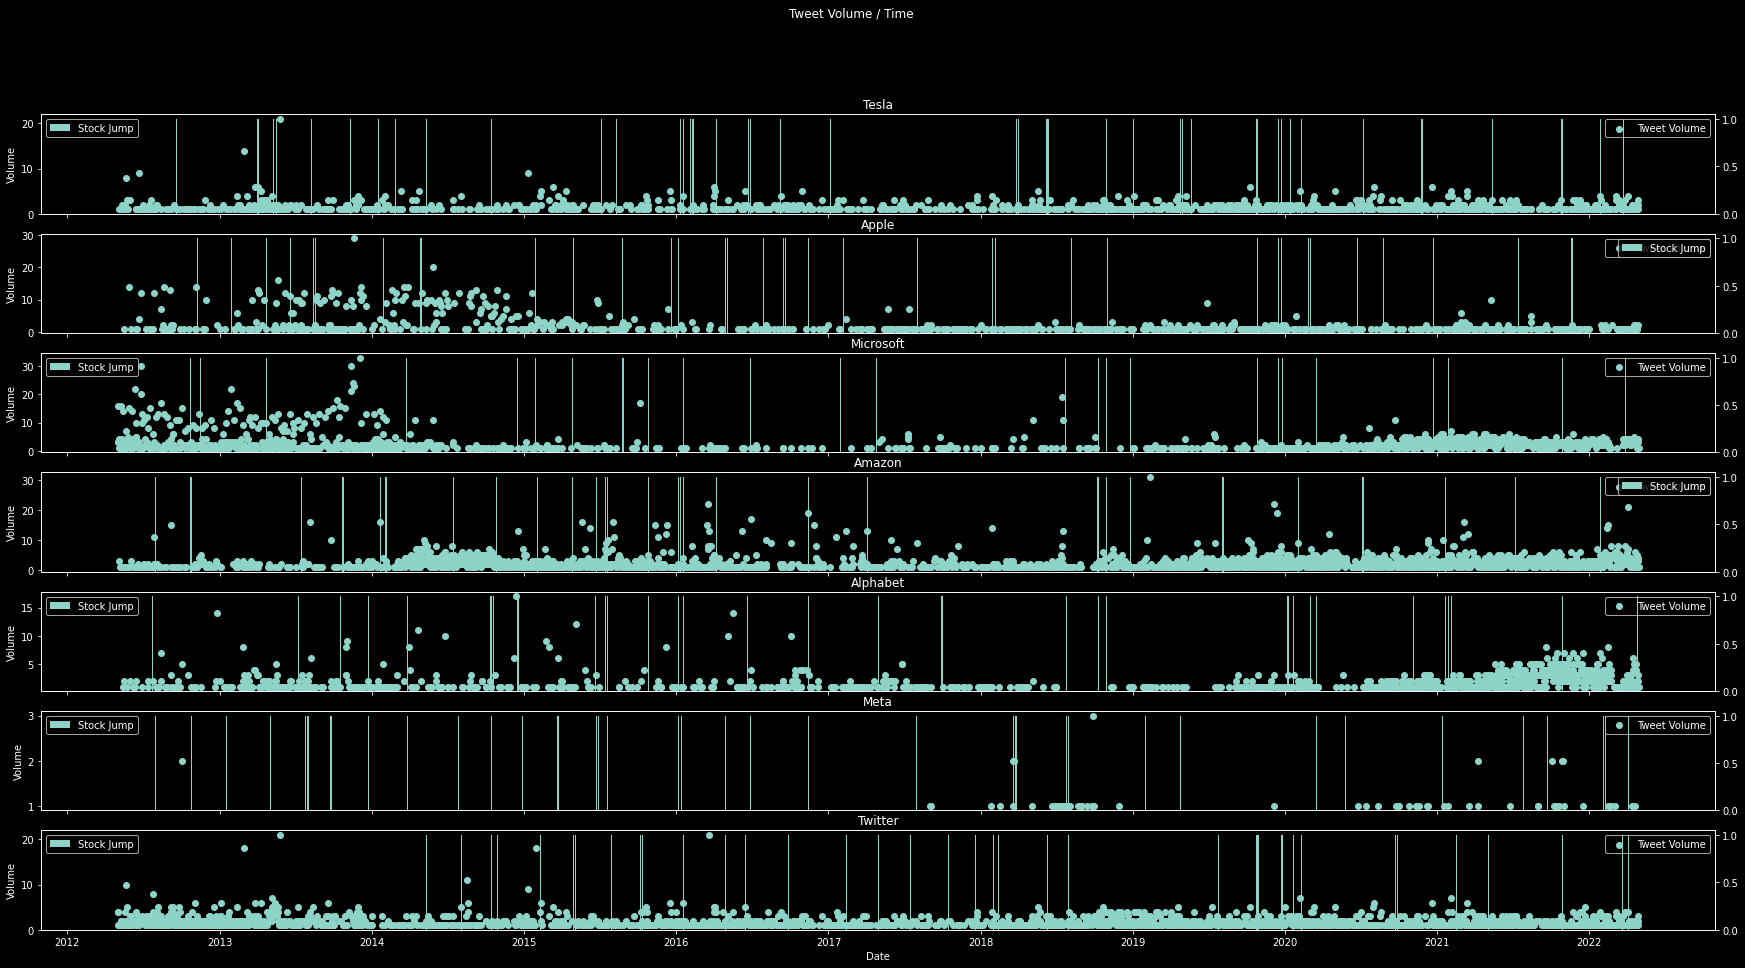

In [34]:
fig, axs = plt.subplots(len(companiesToReview), sharex=True)
fig.suptitle("Tweet Volume / Time")

for i in range(len(companiesToReview)):

	tweetData = GetTweetsFromAboutCompany(companiesToReview[i])
	
	grouped = tweetData.groupby(["Date"]).size().reset_index(name='counts')

	axs[i].set_title(companiesToReview[i]["StockName"])
	axs[i].scatter(grouped["Date"], grouped["counts"], label = "Tweet Volume")
	
	axs[i].set(xlabel='Date', ylabel='Volume')
	axs[i].label_outer()
	axs[i].legend()
	
	ax2 = axs[i].twinx()
	
	stockData = LoadStockData(companiesToReview[i]["Tag"])

	ax2.bar(stockData["Date"], stockData["Both_IsJumping"], label="Stock Jump")
	ax2.legend()


plt.show()

The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

positive sentiment: compound score >= 0.05
neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
negative sentiment: compound score <= -0.05
NOTE: The compound score is the one most commonly used for sentiment analysis by most researchers, including the authors.

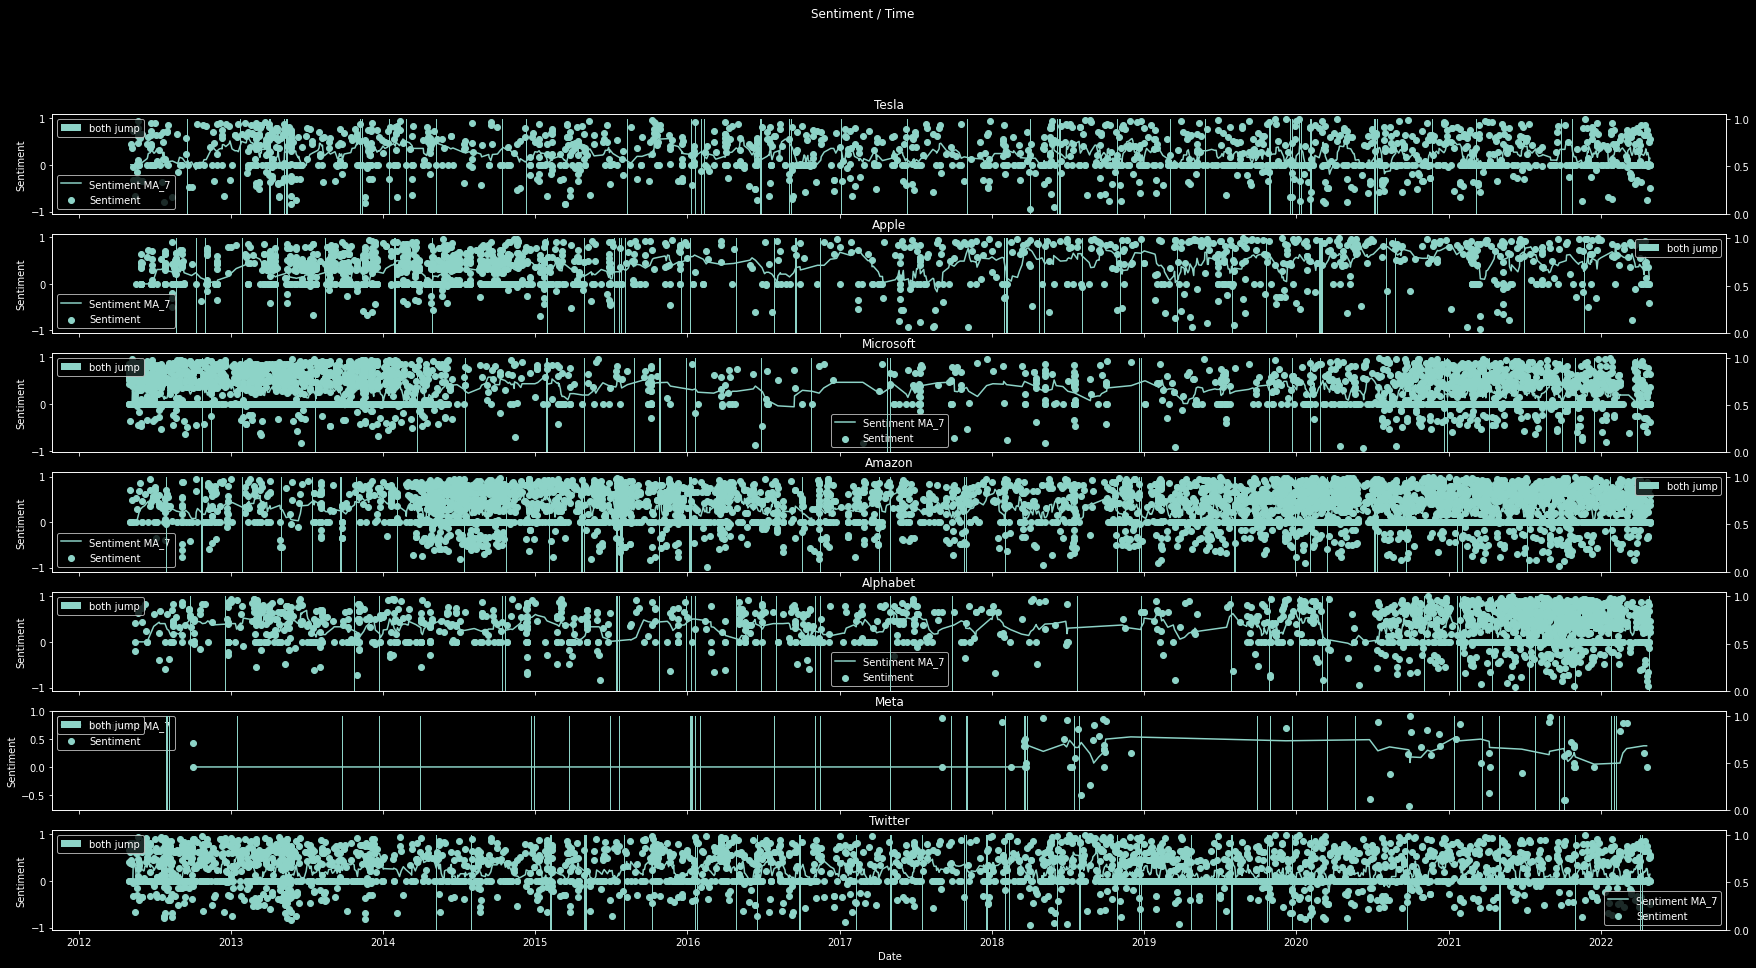

In [35]:
fig, axs = plt.subplots(len(companiesToReview), sharex=True)
fig.suptitle("Sentiment / Time")

for i in range(len(companiesToReview)):

	tweetData = GetTweetsFromAboutCompany(companiesToReview[i])
	
	axs[i].set_title(companiesToReview[i]["StockName"])

	avgSentiment = tweetData.groupby("Date")['Sentiment'].mean().reset_index(name='Sentiment')
	CreateMovingAverage(avgSentiment, "Sentiment", 7)
	axs[i].plot(avgSentiment["Date"], avgSentiment["SentimentMA_7"], label = "Sentiment MA_7")

	
	axs[i].scatter(tweetData["Date"], tweetData["Sentiment"], label = "Sentiment")
	
	axs[i].set(xlabel='Date', ylabel='Sentiment')
	axs[i].label_outer()
	axs[i].legend()
	
	ax2 = axs[i].twinx()
	stockData = LoadStockData(companiesToReview[i]["Tag"])

	ax2.bar(stockData["Date"], stockData["Both_IsJumping"], label="both jump")
	ax2.legend()


plt.show()

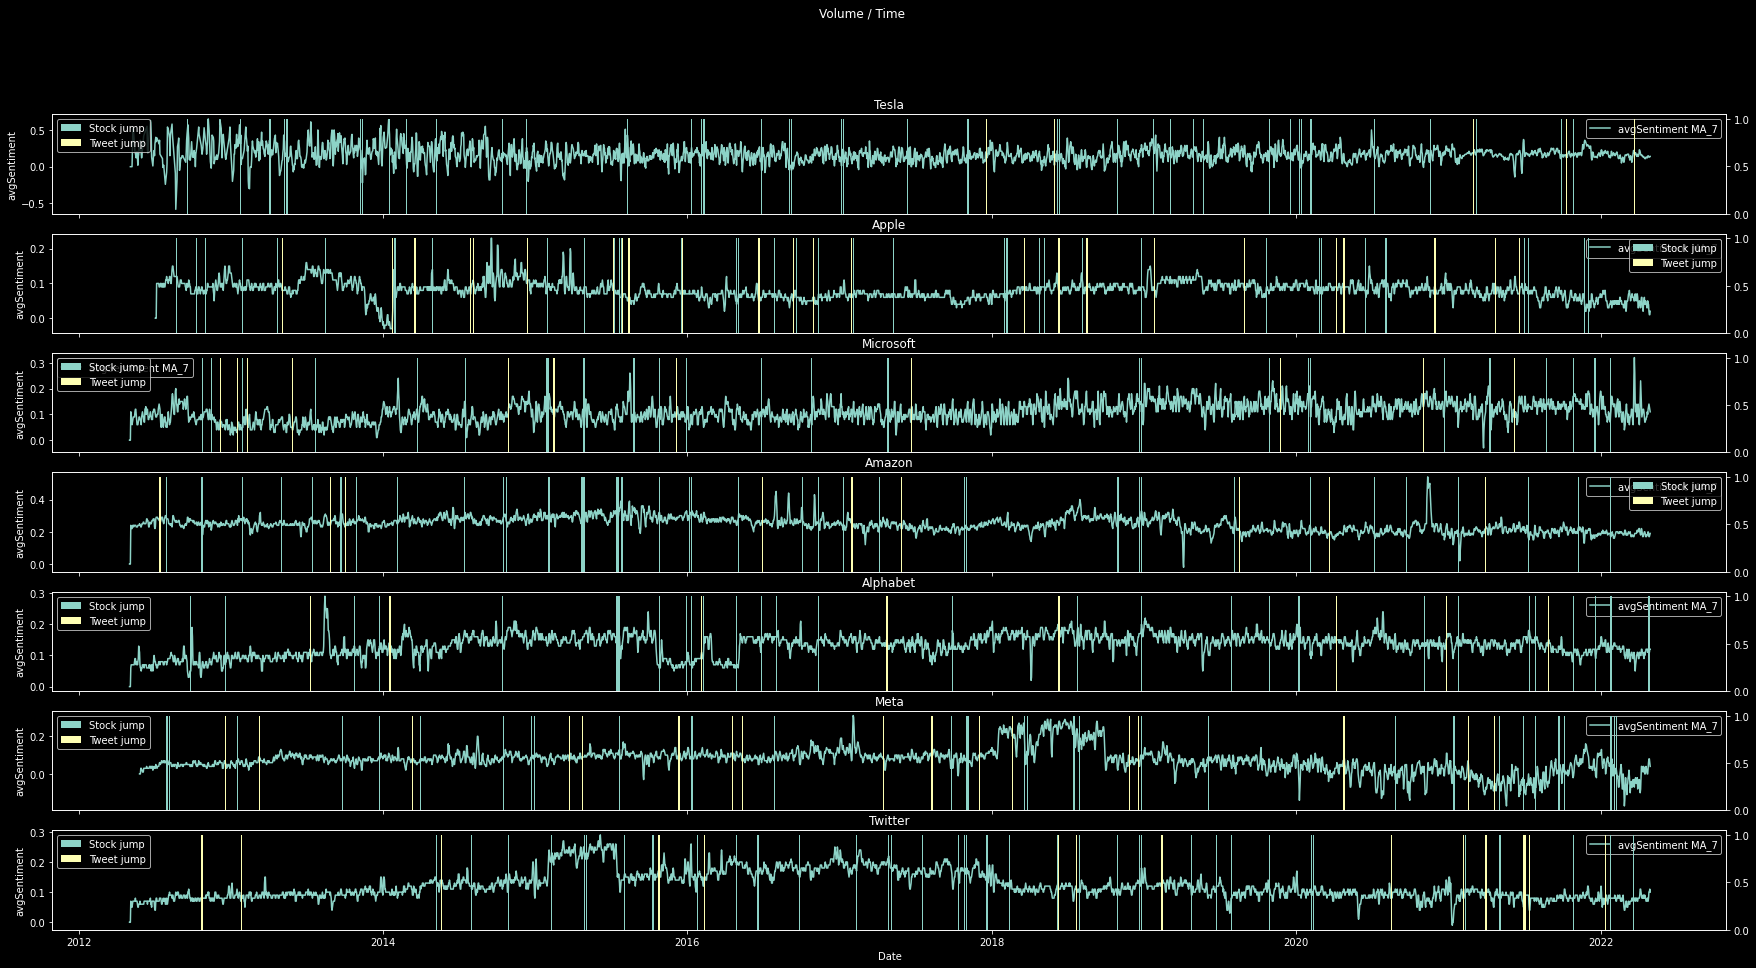

In [36]:
fig, axs = plt.subplots(len(companiesToReview), sharex=True)
fig.suptitle("Volume / Time")

for i in range(len(companiesToReview)):

	tweetData = GetTweetsFromAboutCompany(companiesToReview[i], isPublicOpinion=True)
	
	axs[i].set_title(companiesToReview[i]["StockName"])

	CreateMovingAverage(tweetData, "avgSentiment", 7)

	
	axs[i].plot(tweetData["Date"], tweetData["avgSentimentMA_3"], label = "avgSentiment MA_7")

	axs[i].set(xlabel='Date', ylabel='avgSentiment')
	axs[i].label_outer()
	axs[i].legend()
	
	ax2 = axs[i].twinx()
	stockData = LoadStockData(companiesToReview[i]["Tag"])

	ax2.bar(stockData["Date"], stockData["Both_IsJumping"], label="Stock jump")
	ax2.bar(tweetData["Date"], tweetData["avgSentiment_IsJumping"], label="Tweet jump")
	ax2.legend()


plt.show()

In [37]:
def GetDaysBetweenTweetAndStock(tweetDates, stockDates):
	tweetDates = sorted(tweetDates)
	stockDates = sorted(stockDates)

	daysToJumpList = []
	lastStockIndex = 0
	for tweetDate in tweetDates:

		for i in range(lastStockIndex, len(stockDates)):
			
			stockDate = stockDates[i]
			delta = (stockDate - tweetDate).days
			if delta >= 0:
				lastStockIndex = i
				daysToJumpList.append(delta)
				break



	return daysToJumpList

def AvgDaysBetweenJumps(dates):
	dates = sorted(dates)

	deltas = []
	for i in range(len(dates) - 1):
		deltas.append((dates[i+1] - dates[i]).days)
	return sum(deltas) / len(deltas)

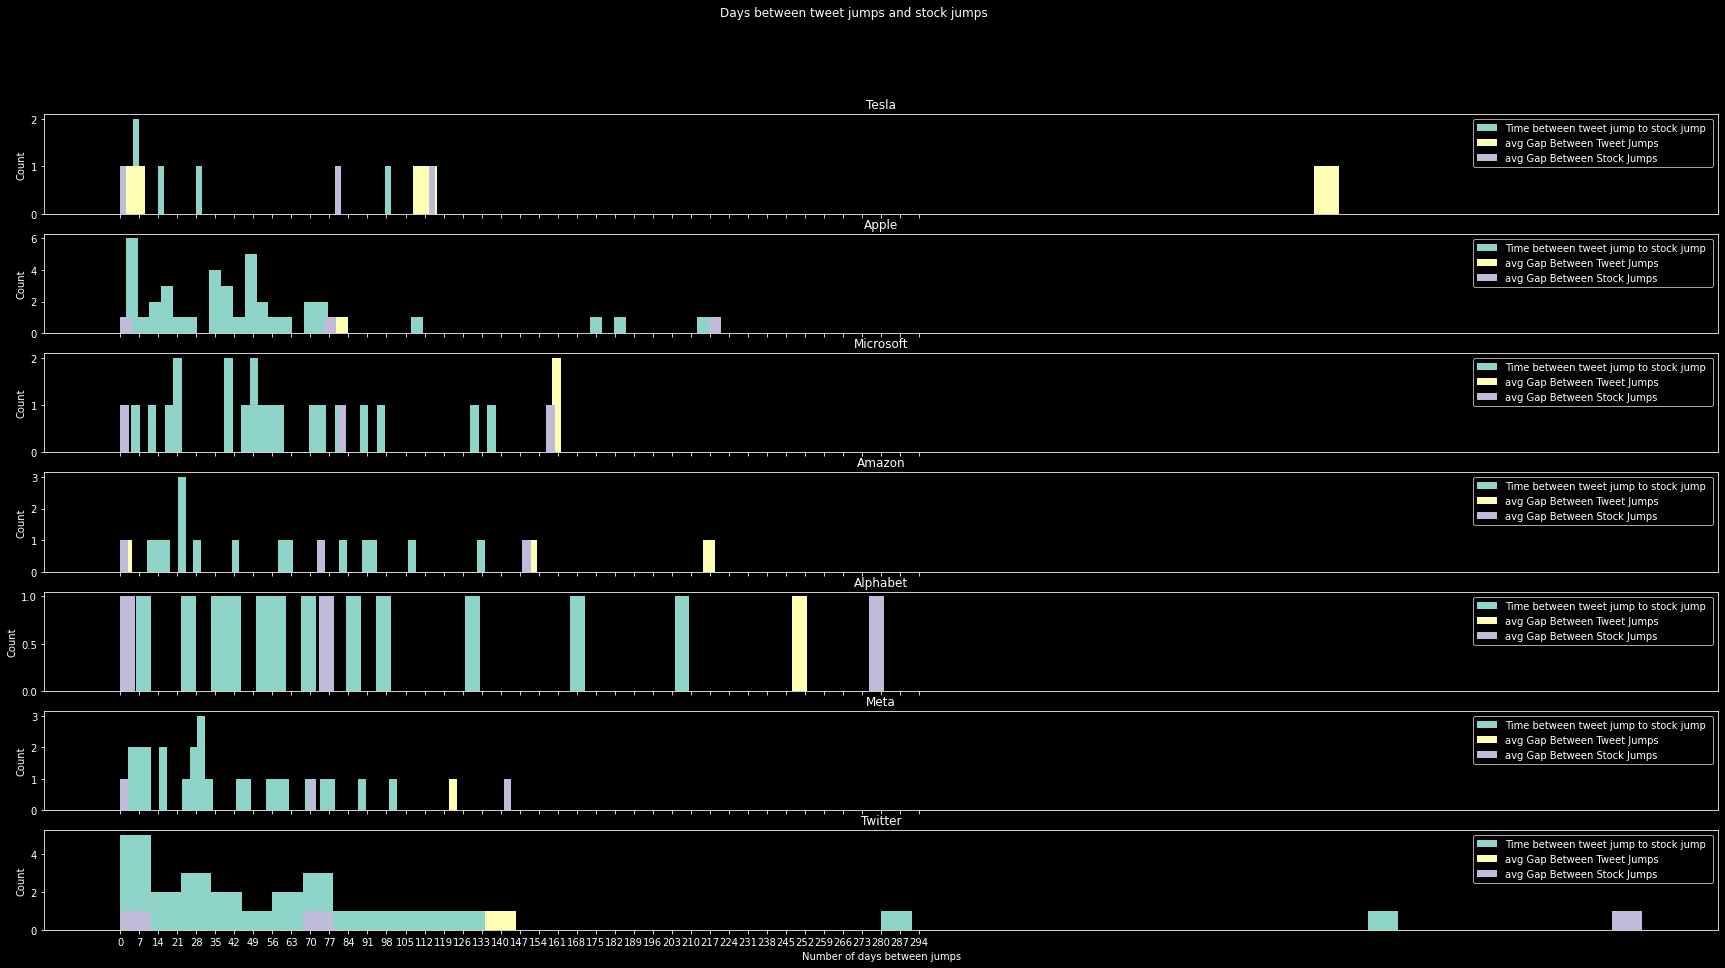

In [47]:
# get the number of days between each tweeter jump and stock jump

fig, axs = plt.subplots(len(companiesToReview), sharex=True)
fig.suptitle("Days between tweet jumps and stock jumps")

for i in range(len(companiesToReview)):
	companyData = companiesToReview[i]
	axs[i].set_title(companyData["StockName"])

	tweetJumpDates = companyData["TweetJumpDates"]
	stockJumpDates = companyData["StockJumpDates"]
	daysToJumpList = GetDaysBetweenTweetAndStock(tweetJumpDates, stockJumpDates)

	avgGapBetweenTweetJumps = AvgDaysBetweenJumps(tweetJumpDates)
	avgGapBetweenStockJumps = AvgDaysBetweenJumps(stockJumpDates)
	
	axs[i].hist(daysToJumpList, 50,  label="Time between tweet jump to stock jump ")

	axs[i].hist([0, avgGapBetweenTweetJumps, max(daysToJumpList)], 50,  label="avg Gap Between Tweet Jumps")
	axs[i].hist([0, avgGapBetweenStockJumps, max(daysToJumpList)], 50,  label="avg Gap Between Stock Jumps")


	axs[i].set(xlabel='Number of days between jumps', ylabel='Count')
	axs[i].label_outer()
	axs[i].xaxis.set_ticks(np.arange(0, 300, 7))
	axs[i].legend()

plt.show()

## Useful Docs

 - https://github.com/JustAnotherArchivist/snscrape
 - https://pypi.org/project/yfinance/
 - https://pandas.pydata.org/docs/reference/frame.html
 - https://matplotlib.org/stable/gallery/index.html